In [2]:
!pip install -q segmentation-models-pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import segmentation_models_pytorch as smp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:0000:01


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class PetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size

        self.valid_imgs = []

        for img_name in sorted(os.listdir(img_dir)):
            mask_name = img_name.replace(".jpg", ".png")
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                self.valid_imgs.append(img_name)

        print(f"✅ Total valid samples: {len(self.valid_imgs)}")

    def __len__(self):
        return len(self.valid_imgs)


    def __getitem__(self, idx):
        img_name = self.valid_imgs[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.size, self.size))
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(
            mask,
            (self.size, self.size),
            interpolation=cv2.INTER_NEAREST
        )

        mask = (mask > 0).astype("float32")

        image = torch.tensor(image).permute(2, 0, 1).float()
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [4]:
device = torch.device("cuda")

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

model = model.to(device)

# 🔥 Multi-GPU
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Using 2 GPUs


In [5]:
train_ds = PetDataset("/kaggle/input/oxford-iiit-pet-preprocessed-for-segmentation/data/images",
                      "/kaggle/input/oxford-iiit-pet-preprocessed-for-segmentation/data/masks")

train_loader = DataLoader(
    train_ds,
    batch_size=8,        # 🔥 batch size badhao (GPU ka fayda)
    shuffle=True,
    num_workers=2,       # Kaggle pe 2–4 enough hota hai
    pin_memory=True
)

✅ Total valid samples: 7335


In [6]:
img, mask = train_ds[0]
print(img.shape, mask.shape)
print(mask.unique())


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
tensor([0., 1.])


In [7]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

model = model.cuda()


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
model.train()

for images, masks in train_loader:
    images = images.cuda()
    masks = masks.cuda()

    preds = model(images)
    loss = criterion(preds, masks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Loss:", loss.item())
    break


Loss: 0.8037882447242737


In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [12]:
from PIL import Image
import os

bad = []

for root, _, files in os.walk("path/to/images"):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg")):
            p = os.path.join(root, f)
            try:
                with Image.open(p) as img:
                    img.verify()
            except Exception:
                bad.append(p)

print("Corrupt images:", len(bad))


Corrupt images: 0


In [14]:
epochs = 3

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch [1/3] - Loss: 0.1280


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch [2/3] - Loss: 0.0907


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch [3/3] - Loss: 0.0788


In [18]:
test_ds = PetDataset(
    img_dir="/kaggle/input/oxford-iiit-pet-preprocessed-for-segmentation/data/images",
    mask_dir="/kaggle/input/oxford-iiit-pet-preprocessed-for-segmentation/data/masks",
    size=256
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


✅ Total valid samples: 7335


In [19]:
model.eval()


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [20]:
criterion = nn.BCEWithLogitsLoss()

total_loss = 0

with torch.no_grad():   # 🔥 no gradient, fast + safe
    for images, masks in test_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        preds = model(images)
        loss = criterion(preds, masks)

        total_loss += loss.item()

avg_test_loss = total_loss / len(test_loader)
print("Test Loss:", avg_test_loss)


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Loss: 0.0706131219337801


In [22]:
def predict_mask(logits, threshold=0.5):
    probs = torch.sigmoid(logits)
    return (probs > threshold).float()


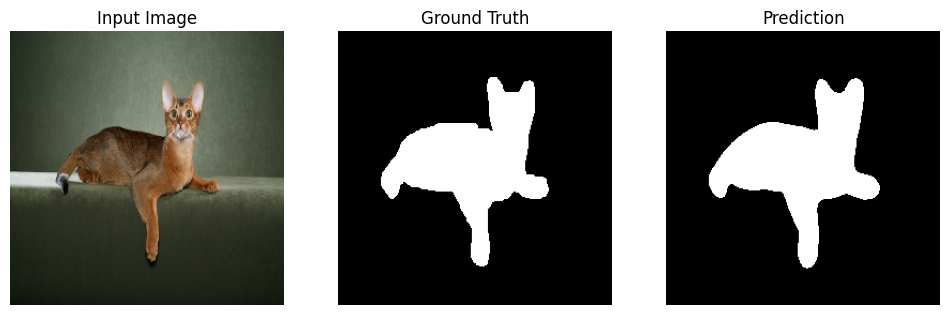

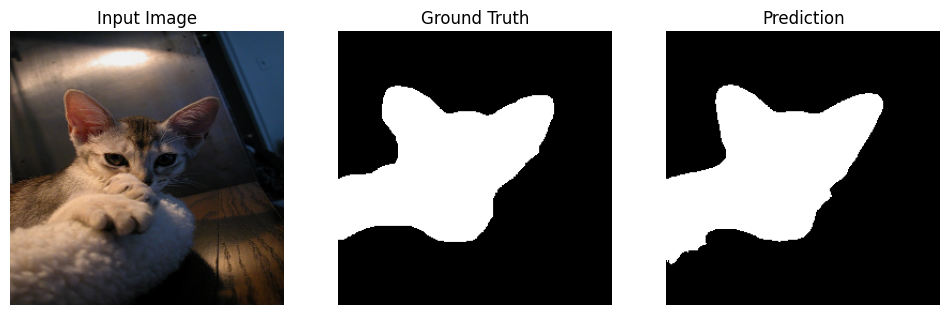

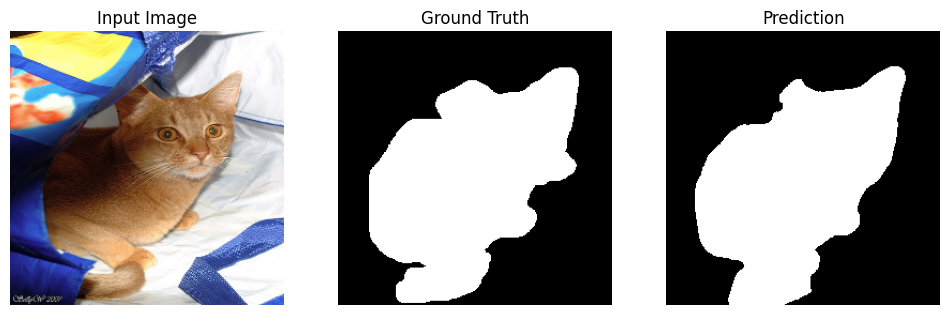

In [23]:
import matplotlib.pyplot as plt

model.eval()

images, masks = next(iter(test_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = predict_mask(preds)

# CPU pe lao for plotting
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

for i in range(3):  # first 3 samples
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i][0], cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
